# PTEN loss Survival Analysis for HNSCC

Imports

In [58]:
import pandas as pd
import cptac
import cptac.utils as ut
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [59]:
'''
Params
cancer_object: Object. The loaded cancer data set.
all_prot: List. trans proteins used to get proteomics data. 
gene_in: String. Gene used to get mutation status for the Mutation col.
utils: utils package from cptac.  

Returns a dataframe with trans proteomics and mutation status of a specific gene.
'''

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN', utils = ut):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad', 'endometrial'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor')
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
            prot_and_mutations = rename_duplicate_cols(prot_and_mutations)
        
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type, how = 'outer')
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    elif cancer_object.get_cancer_type() in ('luad'): 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot, tissue_type = 'tumor')
        omics = utils.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = rename_duplicate_cols(omics)
        omics = omics.drop(columns='PTEN_CNV')
       
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type, how = 'outer') 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
            mut_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
        
    elif cancer_object.get_cancer_type() in ('endometrial'):
        # merge cnv with genotype all mut type
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor') # drop Normal samples

        prot_df = prot_and_mutations.iloc[:,:-4] #drop Mutation and Location cols
        mut_type = mut_type[['Mutation']] # Get Mutation col that includes CNV
        merged = prot_df.join(mut_type, how = 'outer') # merge 

        # Create Truncation category and keep truncation and wt
        compare = ['Wildtype_Tumor','Nonsense_Mutation','Frame_Shift_Ins','Frame_Shift_Del']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
                        mut_wt['Mutation'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')
    
    mut_wt = mut_wt.rename(columns={col: re.sub(r'_proteomics', '', col) for col in mut_wt.columns.tolist()})
    return mut_wt


In [60]:
''' Adds '_i' to duplicate col names where the int i increases by one with each duplicate 
Returns a df with unique column names. '''

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [61]:
def get_survival_cols(cancer_object):
    cancer = cancer_object.get_cancer_type()
    #print(cancer)
    
    # get unique survival col names
    if cancer == 'gbm':
        cols = ['vital_status', 'path_diag_to_last_contact_days', 'path_diag_to_death_days']
    if cancer == 'hnscc':
        cols = ['VITAL_STATUS', 'PATHO_DIAG_TO_LAST_CONT_DAYS', 'PATHO_DIAG_TO_DEATH_DAYS']
    if cancer == 'luad':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    if cancer == 'ovarian':
        cols = ['Vital_Status', 'Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']
    if cancer == 'endometrial':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    
    # lscc no follow up or clin matching survival cols

    if cancer == 'brca':
        cols = ['Vital Status (at time of last contact)'] 
        print('Use csv')
    if cancer == 'colon':
        cols = ['Vital Status (at time of last contact)'] 
        print('Use csv')

    return cols

In [62]:
def get_most_recent_last_contact_df(survival_in):
    d = {}
    df = survival_in[['days_to_last_contact']]
    index_list = list(df.index.unique())
    for i in index_list:
        one_index_df = df.loc[[i]]
        # Get the latest number when duplicate records
        most_recent = one_index_df['days_to_last_contact'].max() # get most recent (highest num)
        d[i] = most_recent
        
    last_contact_df = pd.DataFrame.from_dict(d, orient='index', columns=['days_to_last_contact'])
    last_contact_df.index.name = 'Patient_ID'
    
    return last_contact_df   

# Step 1: Import data

In [63]:
cancer = 'HNSCC'
ca = cptac.Hnscc()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 2)


# Check data

In [65]:
cols = get_survival_cols(ca)

f = ca.get_followup(tissue_type = 'tumor')
df2 = f[cols]
df3 = df2.rename(columns = {cols[0]: 'vital_status', cols[1]: 'days_to_last_contact', cols[2]: 'days_to_death'})
print('followup\n', df3.vital_status.value_counts(), '\n')

clin = ca.get_clinical(tissue_type = 'tumor')
print('clin\n', clin.follow_up_vital_status.value_counts())
cd = clin[['follow_up_days', 'follow_up_vital_status']]
cdf = cd.rename(columns = {'follow_up_days': 'days_to_last_contact_or_death', 'follow_up_vital_status': 'vital_status'})

followup
 Living      128
Deceased     12
Name: vital_status, dtype: int64 

clin
 Living      87
Deceased    14
Name: follow_up_vital_status, dtype: int64


In [22]:
fd = df3.loc[df3['vital_status'] == 'Deceased']
followup_list = list(fd.index)
print('num death events in followup:', len(followup_list))

cd = cdf.loc[cdf['vital_status'] == 'Deceased']
clin_list = list(cd.index)
print('num death events in clin:', len(clin_list))

num death events in followup: 12
num death events in clin: 14


Find samples in clin and not in followup (with death events)

In [24]:
# Find samples in clin and not in followup (with death events)
only_in_clin = [e for e in clin_list if e not in followup_list]
len(only_in_clin)
only_in_clin

['C3N-00828', 'C3N-03009']

In [70]:
a = 'C3N-00828'
#a = 'C3N-03009'
print('clin')
cd.loc[[a]]

clin


Name,follow_up_days,follow_up_vital_status
Patient_ID,,
C3N-00828,951.0,Deceased


In [71]:
print('followup')
df2.loc[a]

followup


Name,VITAL_STATUS,PATHO_DIAG_TO_LAST_CONT_DAYS,PATHO_DIAG_TO_DEATH_DAYS
Patient_ID,,,
C3N-00828,Living,393,NaN
C3N-00828,Living,635,NaN
C3N-00828,Living,826,NaN


Check the 2 samples with negative days

In [66]:
# check samples with neg days to death
a = ['C3L-00995', 'C3N-00299']
print('followup')
df2.loc[a]

followup


Name,VITAL_STATUS,PATHO_DIAG_TO_LAST_CONT_DAYS,PATHO_DIAG_TO_DEATH_DAYS
Patient_ID,,,
C3L-00995,Deceased,-10,-9.0
C3N-00299,Deceased,-15,294.0


In [67]:
print('clin')
cd.loc[a]

clin


Name,follow_up_days,follow_up_vital_status
Patient_ID,,
C3L-00995,-10.0,Deceased
C3N-00299,-15.0,Deceased


# Prepare Data for Multivariate Kaplan Meier Plots and Cox's Proportional Hazard Test

In [31]:
clin = ca.get_clinical(tissue_type = 'tumor')
print(clin.follow_up_vital_status.value_counts())
df = clin[['follow_up_days', 'follow_up_vital_status']]
df = df.rename(columns = {'follow_up_days': 'days_to_last_contact_or_death', 'follow_up_vital_status': 'vital_status'})

Living      87
Deceased    14
Name: follow_up_vital_status, dtype: int64


In [33]:
del_wt = all_prot_format_df(ca, ['PTEN']) # get Mutation col (PTEN del/wt)
mut_survival = df.join(del_wt, on = 'Patient_ID', how = 'left') # combine keeping only turmors

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-02617, C3N-02727 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation ta

In [34]:
# Drop row with NaN in vital status : (99 rows)
mut_survival = mut_survival[mut_survival['vital_status'].notna()]
mut_survival = mut_survival[mut_survival['days_to_last_contact_or_death'].notna()]
mut_survival = mut_survival[mut_survival['Mutation'].notna()]
len(mut_survival)

99

In [35]:
#Make the vital_status column boolean
mut_survival['vital_status'] = mut_survival['vital_status'].replace('Living', False) # deceased = True
mut_survival['vital_status'] = mut_survival['vital_status'].astype('bool') # careful: nan vals will change to bool
df_genes = mut_survival

mut_survival.vital_status.value_counts()

False    85
True     14
Name: vital_status, dtype: int64

In [36]:
# map numeric values to correspond with mutation status
mutation_map = {"Wildtype_Tumor" : 0, "Deletion" : 1}

df_genes['PTEN'] = df_genes['Mutation'].map(mutation_map)

#Then we will drop missing values, as missing values 
#will throw an error in the functions we will use in lifelines.
df_clean = df_genes.dropna(axis=0, how='any').copy()
df_clean = df_clean.drop(columns= 'Mutation') # drop col with str values (info mapped to PTEN as int)

In [37]:
print(df_clean.vital_status.value_counts())
print(df_clean.PTEN.value_counts())

False    85
True     14
Name: vital_status, dtype: int64
0    82
1    17
Name: PTEN, dtype: int64


Verify that your columns are the correct data types.  The event of interest, in this case Vital_Status needs to contain boolean values, and all other columns in the table must be of a numeric type (either int64 or float64).

In [39]:
for col in df_clean.columns:
    print(col, ":", df_clean[col].dtype)

days_to_last_contact_or_death : float64
vital_status : bool
PTEN : int64


In [ ]:
# check mirroring

In [40]:
wt = df_clean.loc[df_clean['PTEN'] == 0]
ch = {'test': [1200, False, 1], 't2': [800, True, 1], 't3':[200, True, 1], 't4': [300, True, 1], 't5': [600, True, 1]}
cols = ['days_to_last_contact_or_death', 'vital_status', 'PTEN']
test = pd.DataFrame.from_dict(ch, orient = 'index', columns = cols)
tdf = wt.append(test)

In [54]:
ch = {'test2': [1200, True, 0], 'd2': [800, True, 0], 'd3':[200, True, 0], 'd4': [300, True, 0]}
cols = ['days_to_last_contact_or_death', 'vital_status', 'PTEN']
test2 = pd.DataFrame.from_dict(ch, orient = 'index', columns = cols)
tdf = test.append(test2)
tdf

,days_to_last_contact_or_death,vital_status,PTEN
test,1200,False,1
t2,800,True,1
t3,200,True,1
t4,300,True,1
t5,600,True,1
test2,1200,True,0
d2,800,True,0
d3,200,True,0
d4,300,True,0


# Step 5: Plot Multivariate Survival Risk

0 is wt. 1 is mutant.

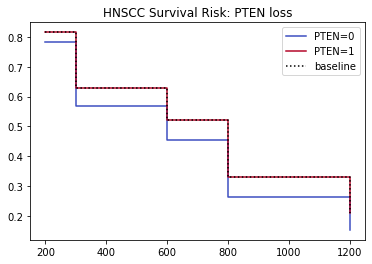

In [55]:
plot_title = cancer+" Survival Risk: PTEN loss"

cph = CoxPHFitter()
cph.fit(tdf, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")
cph.plot_partial_effects_on_outcome('PTEN', [0,1], cmap='coolwarm', title=plot_title)    


In [57]:
cph.check_assumptions(tdf)

Proportional hazard assumption looks okay.


[]

In [56]:
cph.params_

covariate
PTEN   -0.188063
Name: coef, dtype: float64

In [52]:
cph.hazard_ratios_

covariate
PTEN    1.688784
Name: exp(coef), dtype: float64

In [53]:
cph.print_summary(model="untransformed variables", decimals=3)


<lifelines.CoxPHFitter: fitted with 6 total observations, 1 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 6
number of events observed = 5
   partial log-likelihood = -6.466
         time fit was run = 2020-11-13 22:35:39 UTC
                    model = untransformed variables

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
PTEN       0.524      1.689      1.151           -1.732            2.780                0.177               16.125

              z     p   -log2(p)
covariate                       
PTEN      0.455 0.649      0.624
---
Concordance = 0.600
Partial AIC = 14.932
log-likelihood ratio test = 0.226 on 1 df
-log2(p) of ll-ratio test = 0.657

# Step 6: Cox's Proportional Hazard Test

With the proportional_hazard_test function, we can now perform Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival. This is shown by the hazard ratio in the column labeled -log2(p) below. In general, a hazard ratio of 1 suggests that an attribute has no effect on overall survival. A ratio less than 1 suggests that an attribute contributes to lower survival risk. A ratio greater than 1 suggests that an attribute contributes to higher survival risk.

In [ ]:
results = proportional_hazard_test(cph, df_clean, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

Below, we show the confidence interval for the hazard ratio. 

In [ ]:
plt.title(cancer)
cph.plot()

In [ ]:
# log(hazards ratio) = coef = -0.192

Conclusions: Because the p-value was greater than 0.05, there is insufficient evidence to suggest the PTEN loss effects survival risk.